# Barotropic streamfunction

In [1]:
from cycler import cycler
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib.colors as mcolors
from distributed import Client
from ncar_jobqueue import NCARCluster
import os

/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = NCARCluster(cores=4,
    processes=1,
    resource_spec='select=1:ncpus=1:mem=50GB',
)
cluster.scale(10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.55:37924,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Open NW2 data

In [3]:
exp_list = [
    r'$1/4^\circ$', 
    r'$1/8^\circ$', 
    r'$1/16^\circ$', 
    r'$1/32^\circ$'
]
run_list = [
    'nw2_0.25deg_N15_baseline_hmix5',
    'nw2_0.125deg_N15_baseline_hmix5',
    'nw2_0.0625deg_N15_baseline_hmix5',
    'nw2_0.03125deg_N15_baseline_hmix5'
]

In [4]:
chunks = {'time': 1}
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'

coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}}

metrics = {('X',):['dxCu','dxCv','dxT','dxBu'],
           ('Y',):['dyCu','dyCv','dyT','dyBu']
          }

lm_list = []
av_list = []
st_list = []
av_start_time_list = []
lm_start_time_list = []

for run in run_list:
    st = xr.open_dataset('%s/%s/static.nc' % (path, run), decode_times=False)
    grid = Grid(st, coords=coords, periodic=['X'])
    dyT = grid.interp(st.dyCu,axis='X')
    dxT = grid.interp(st.dxCv,axis='Y')
    st['dxT'] = dxT
    st['dyT'] = dyT
    st_list.append(st)
    
    # long mean
    lm = xr.open_mfdataset('%s/%s/longmean_*.nc' % (path, run),
                           chunks=chunks, decode_times=False,
                          parallel=True)
    
    vh_lm = grid.interp(lm.vh,axis='Y')
    uh_lm = grid.interp(lm.uh,axis='X')
    lm['vh_h'] = vh_lm
    lm['uh_h'] = uh_lm
    lm_list.append(lm)
    print('LM 1/%i nt=%i ts=%f te=%f'%(len(lm.xh)//60,len(lm.time),lm.time[0],lm.time[-1]))
    lm_start_time = 1.5*lm.time[0]-0.5*lm.time[1]
    lm_start_time_list.append(lm_start_time)
    
    # 5-day averages
    av = xr.open_mfdataset('%s/%s/averages_*.nc' % (path, run),
                           chunks=chunks, decode_times=False,
                          parallel=True)
    
    vh = grid.interp(av.vh,axis='Y')
    uh = grid.interp(av.uh,axis='X')
    av['vh_h'] = vh
    av['uh_h'] = uh
    av_list.append(av)
    print('AV 1/%i nt=%i ts=%f te=%f'%(len(av.xh)//60,len(av.time),av.time[0],av.time[-1]))
    av_start_time = 1.5*av.time[0]-0.5*av.time[1]
    av_start_time_list.append(av_start_time)

LM 1/4 nt=320 ts=50.000000 te=31950.000000
AV 1/4 nt=400 ts=30002.500000 te=31997.500000
LM 1/8 nt=50 ts=50.000000 te=4950.000000
AV 1/8 nt=1000 ts=2.500000 te=4997.500000
LM 1/16 nt=50 ts=50.000000 te=4950.000000
AV 1/16 nt=200 ts=4002.500000 te=4997.500000
LM 1/32 nt=28 ts=50.000000 te=2750.000000
AV 1/32 nt=160 ts=2002.500000 te=2797.500000


## Plot

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 20}
pylab.rcParams.update(params)

In [17]:
import warnings
warnings.filterwarnings("ignore")

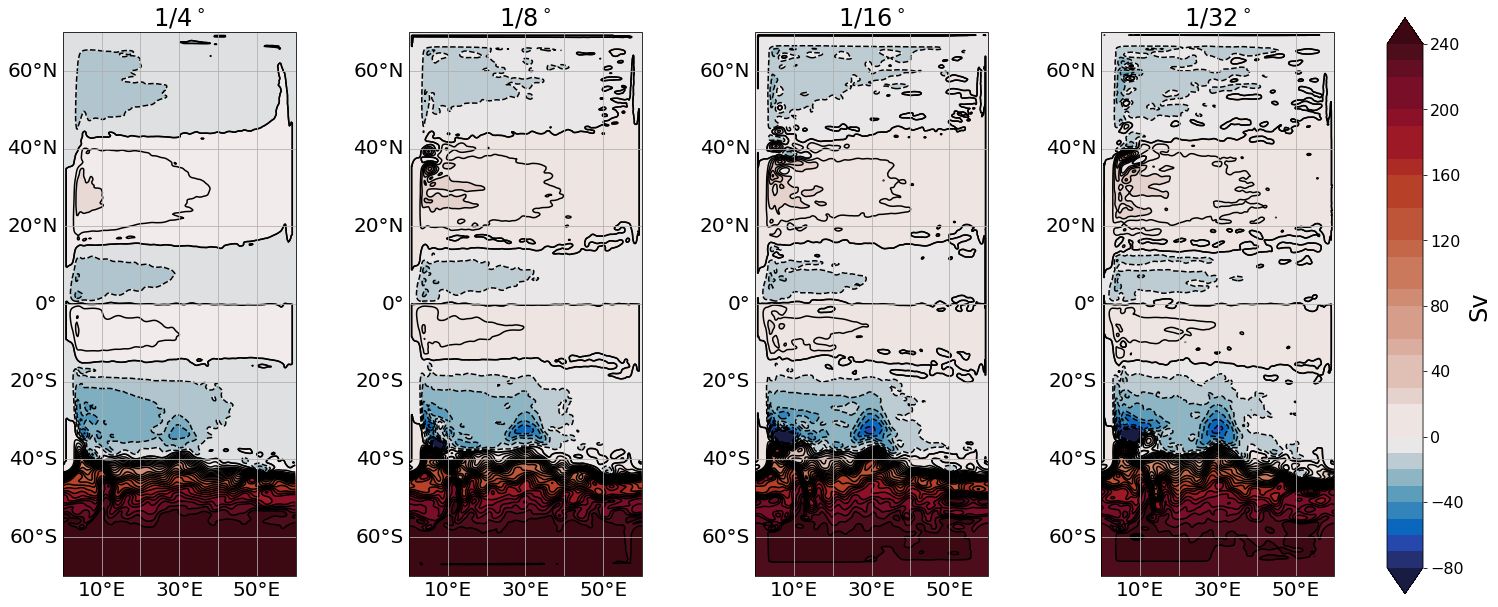

In [19]:
vmin = -80
vmax = 250
norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax = vmax, vcenter=0)
levs = np.arange(vmin, vmax, 10)
levs1 = np.arange(-60,180,25)
unit = 'Sv'

fig,axs = plt.subplots(1,4,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})

for exp, lm1, st, ax in zip(exp_list, lm_list, st_list, axs.flatten()):
    lm = lm1.isel(time=slice(-6,None)) # last 500 days
    verticalsum = (lm.uh_h).sum('zl')
    int_from_right = (-(verticalsum).cumsum(dim='yh') + (verticalsum).sum(dim='yh'))
    mag = (int_from_right.mean("time")/1.0e6)
    U = lm.uh_h.sum('zl').mean('time')
    V = lm.vh_h.sum('zl').mean('time')
 
    p = mag.plot.contourf(
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        levels=levs,
        cmap=cm.cm.balance,
        transform=ccrs.PlateCarree(),
        norm=norm,
        add_colorbar=False
    )
    mag.plot.contour(
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        levels=levs,
        transform=ccrs.PlateCarree(),
        colors='k', lw = 0.5,
    )

    mag.plot.contour(
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        levels=[0.],
        transform=ccrs.PlateCarree(),
        colors='k', lw = 20,
    )
    
    ax.set(title=exp)
    ax.set_extent([0, 60, -70, 70], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.2)
cax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cax, label=unit, extend='both')
cbar.ax.tick_params(labelsize=16) 

plt.savefig('mean_barotropic_transport_contours.png', bbox_inches='tight', pad_inches=0)